# Regression and Classification with Fully Connected Neural Networks

## Imports

In [1]:
import torch
from torch import nn
import numpy as np
from torch.distributions import bernoulli
import matplotlib.pyplot as plt

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Tasks to solve in this notebook

Main types of supervised machine learning:
1. Regression: estimation of continuous quantities
2. Classification: estimation of categories or discrete quantities

### Regression

In [2]:
# make some fake regression data
n_samples_reg = 100
x_reg = 1.5*torch.randn(n_samples_reg, 1)
y_reg = 2 * x_reg + 3.0*torch.sin(3*x_reg) + 1 + 2 * torch.randn(n_samples_reg, 1)
y_reg = y_reg.squeeze()

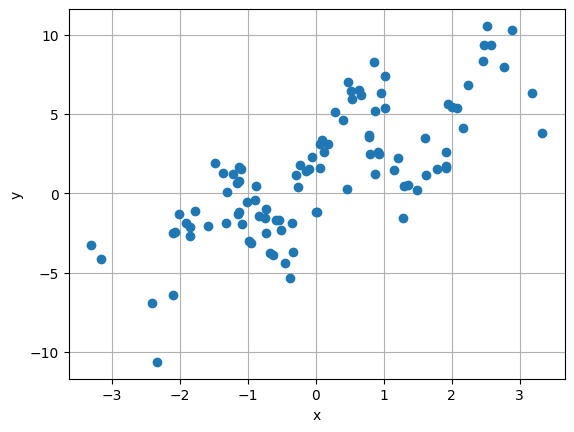

In [3]:
plt.plot(x_reg, y_reg, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

### Classification

In [4]:
# fake classification data
n_samples_clf = 200
x_clf = 2.5*torch.randn(n_samples_clf, 2)
d = torch.sqrt( x_clf[:, 0]**2 +  x_clf[:, 1]**2 )
y_clf = (torch.sin(d) > 0) & (d<torch.pi)

# swap some labels near the boundary
width = 0.7
pgivd = 0.3 * width**2 / ((d - torch.pi)**2 + width**2)
swaps = bernoulli.Bernoulli(pgivd).sample().type(torch.bool)
y_clf[swaps] = ~y_clf[swaps]

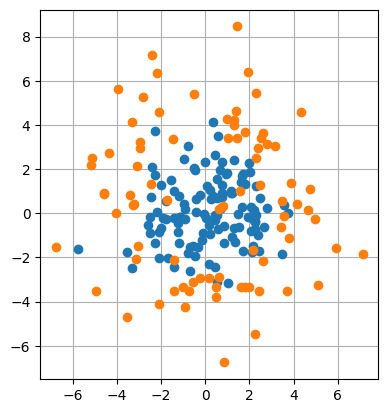

In [5]:
plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
plt.gca().set_aspect(1)
plt.grid()

## The Simplest "Deep Learning" Model: Linear Regression

### Initializing our model

Good old fashioned linear model: $y = wx + b$. 

In [6]:
# Pytorch's `nn` module has lots of neural network building blocks
# nn.Linear is what we need for y=wx+b
reg_model = nn.Linear(in_features = 1, out_features = 1)

---

**Question**: What do you think the arguments `in_features` and `out_features` mean? When might they not be 1?

---

In [7]:
# pytorch randomly initializes the w and b
reg_model.weight, reg_model.bias

(Parameter containing:
 tensor([[-0.8761]], requires_grad=True),
 Parameter containing:
 tensor([-0.5502], requires_grad=True))

In [8]:
# let's look at some predictions
with torch.no_grad():
    y_reg_init = reg_model(x_reg)
    
y_reg_init[:5]

tensor([[-3.0825],
        [-2.5047],
        [-1.7339],
        [ 2.2167],
        [-1.4418]])

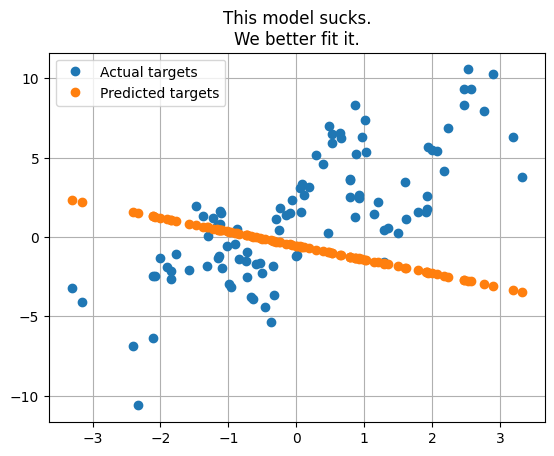

In [9]:
# plot the predictions before training the model
plt.plot(x_reg, y_reg, 'o', label='Actual targets')
plt.plot(x_reg, y_reg_init, 'o', label='Predicted targets')
plt.grid()
plt.legend()
_ = plt.title("This model sucks.\nWe better fit it.")

### Anatomy of a training loop

Basic idea: 
* Start with random parameter values
* Define a loss/cost/objective measure to optimize
* Use training data to evaluate the loss
* Update the model to reduce the loss (use gradient descent)
* Repeat until converged

Basic weight update formula: 
$
w_{i+1} = w_i - \mathrm{lr}\times \left.\frac{\partial L}{\partial w}\right|_{w=w_i}
$

---

**Question**: Why the minus sign in front of the second term? 

---

<img src="https://github.com/clemsonciti/rcde_workshops/raw/master/pytorch/fig_grad_descent.png" alt="grad descent" width="500"/>


Epoch 1. MSE Loss = 24.350
Epoch 21. MSE Loss = 9.776
Epoch 41. MSE Loss = 7.300
Epoch 61. MSE Loss = 6.871
Epoch 81. MSE Loss = 6.793


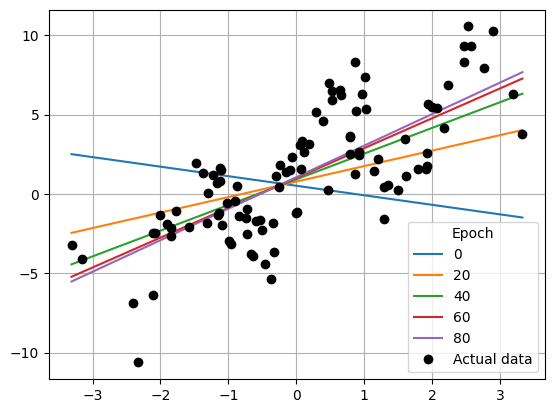

In [10]:
# re-initialize our model each time we run this cell
# otherwise the model picks up from where it left off
reg_model = nn.Linear(in_features = 1, out_features = 1)

# the torch `optim` module helps us fit models
import torch.optim as optim

# create our optimizer object and tell it about the parameters in our model
# the optimizer will be responsible for updating these parameters during training
optimizer = optim.SGD(reg_model.parameters(), lr=0.01)

# how many times to update the model based on the available data
num_epochs = 100
for i in range(num_epochs):
    # make sure gradients are set to zero on all parameters
    # by default, gradients accumulate
    optimizer.zero_grad()
    
    # "forward pass"
    y_hat = reg_model(x_reg).squeeze()
    
    # measure the loss
    # this is the mean squared error
    loss = torch.mean((y_hat - y_reg)**2)
    # can use pytorch built-in: https://pytorch.org/docs/stable/generated/torch.nn.functional.mse_loss.html
    
    # "backward pass"
    # that is, compute gradient of loss wrt all parameters
    loss.backward()
    
    # parameter updates
    # use the basic weight update formula given above (with slight modifications)
    optimizer.step()
    
    if i % 20 == 0:
        print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")
        with torch.no_grad():
            y_reg_init = reg_model(x_reg)
        
        ix = x_reg.argsort(axis=0).squeeze()
        plt.plot(x_reg.squeeze()[ix], y_reg_init.squeeze()[ix], '-', label=i, alpha=1)


plt.plot(x_reg, y_reg, 'ok', label="Actual data")
plt.grid()
_ = plt.legend(title='Epoch')

---

**Question**: What shortcomings does this model have? 

---

---

🔥**IMPORTANT CONCEPT**🔥 Model bias is a type of error that occurs when your model doesn't have enough flexibility to represent the real-world data!

---

## Linear classification

### A slight modification to the model

We need to modify our model because the outputs are true/false

In [11]:
y_clf.unique()

tensor([False,  True])

While training the model, we cannot simply threshold the model outputs (e.g. call outputs greater than 0 'True'). Instead, we can have our model output a continuous number between 0 and 1. Use sigmoid to transform the output of a linear model to the range (0,1):
$$
p(y=1 | \vec{x}) = \mathrm{sigmoid}(\vec w \cdot \vec x + b)
$$

---

**Question**: Why doesn't thresholding work while training? 

---

---

🔥**IMPORTANT CONCEPT**🔥 In order to use gradient descent, neural networks must be differentiable. 

---

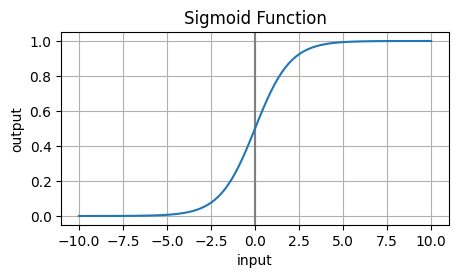

In [12]:
# what is sigmoid?
x_plt = torch.linspace(-10,10, 100)
y_plt = torch.sigmoid(x_plt)
plt.axvline(0, color='gray')
plt.plot(x_plt, y_plt)
plt.grid()
plt.xlabel('input')
plt.ylabel('output')
plt.gcf().set_size_inches(5,2.5)
_ = plt.title('Sigmoid Function')

In [13]:
# proposed new model for classification
# use nn.Sequential to string operations together
model_clf = nn.Sequential(
    nn.Linear(2, 1), # notice: we now have two inputs
    nn.Sigmoid()  # sigmoid squishes real numbers into (0, 1)
)

In [14]:
# what do the outputs look like?
with torch.no_grad():
    print(model_clf(x_clf)[:10])
# notice how they all lie between 0 and 1
    
# we loosely interpret these numbers as
# "the probability that y=1 given the provided value of x"

tensor([[0.6701],
        [0.8487],
        [0.7813],
        [0.4899],
        [0.8440],
        [0.2253],
        [0.3412],
        [0.4453],
        [0.4484],
        [0.5387]])


In [15]:
# turning probabilities into "decisions"
# apply a threshold
with torch.no_grad():
    print(model_clf(x_clf)[:10] > 0.5)

tensor([[ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True]])


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/envs/pytorch_workshop/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


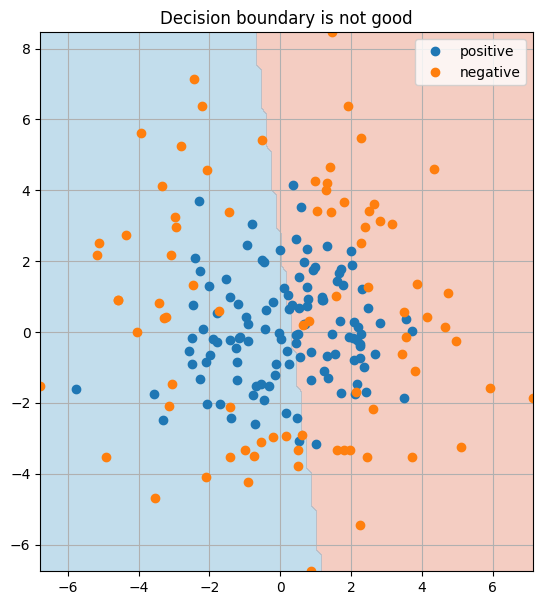

In [16]:
# let's see how this model does before any training

# Code to plot the decision regions
x_clf.min(), x_clf.max()
xx, yy = mg = torch.meshgrid(
    torch.linspace(x_clf[:,0].min(), x_clf[:,0].max(), 100),
    torch.linspace(x_clf[:,1].min(), x_clf[:,1].max(), 100)
)
grid_pts = torch.vstack([xx.ravel(), yy.ravel()]).T

with torch.no_grad():
    # use a 0.5 decision threshold
    grid_preds = model_clf(grid_pts).squeeze()>0.5

grid_preds = grid_preds.reshape(xx.shape)

plt.gcf().set_size_inches(7,7)
plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
plt.gca().set_aspect(1)
plt.grid()
plt.contourf(xx, yy, grid_preds, cmap=plt.cm.RdBu, alpha=0.4)
plt.legend()
_ = plt.title("Decision boundary is not good")

### Training loop

The main difference between regression and classification is the loss function. For regression, we used mean squared error. For classification, we will use cross-entropy loss. This loss formula encourages the model to output low values for $p(y=1|x)$ when the class is 0 and high values when the class is 1. 

In [17]:
# re-initialize our model each time we run this cell
# otherwise the model picks up from where it left off
model_clf = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

# create our optimizer object and tell it about the parameters in our model
optimizer = optim.SGD(model_clf.parameters(), lr=0.01)

# torch needs the class labels to be zeros and ones, not False/True
y_clf_int = y_clf.type(torch.int16)

# how many times to update the model based on the available data
num_epochs = 1000
for i in range(num_epochs):
    optimizer.zero_grad()
    
    y_hat = model_clf(x_clf).squeeze()
    
    # measure the goodness of fit
    # need to use a different loss function here
    # this is the "cross entropy loss"
    loss = -y_clf_int * torch.log(y_hat) - (1-y_clf_int)*torch.log(1-y_hat)
    loss = loss.mean()
    # pytorch built-in: https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html
    
    # update the model
    loss.backward() # gradient computation
    optimizer.step()  # weight updates
    
    if i % 100 == 0:
        print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")

Epoch 1. MSE Loss = 0.959
Epoch 101. MSE Loss = 0.774
Epoch 201. MSE Loss = 0.727
Epoch 301. MSE Loss = 0.705
Epoch 401. MSE Loss = 0.691
Epoch 501. MSE Loss = 0.683
Epoch 601. MSE Loss = 0.678
Epoch 701. MSE Loss = 0.675
Epoch 801. MSE Loss = 0.673
Epoch 901. MSE Loss = 0.672


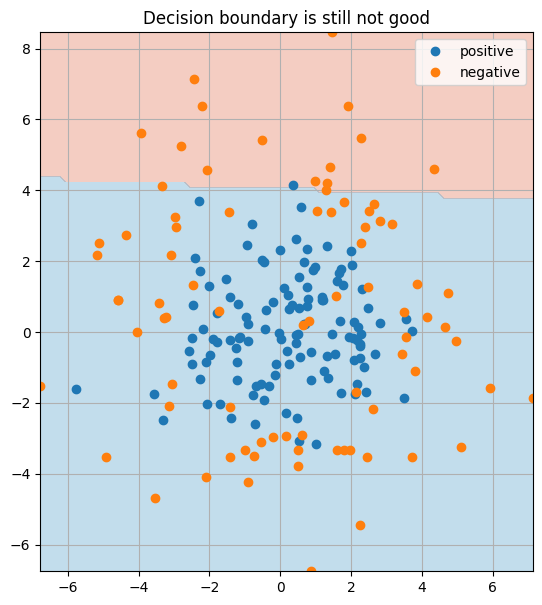

In [18]:
with torch.no_grad():
    # use a 0.5 decision threshold
    grid_preds = model_clf(grid_pts).squeeze()>0.5

grid_preds = grid_preds.reshape(xx.shape)

plt.gcf().set_size_inches(7,7)
plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
plt.gca().set_aspect(1)
plt.grid()
plt.contourf(xx, yy, grid_preds, cmap=plt.cm.RdBu, alpha=0.4)
plt.legend()
_ = plt.title("Decision boundary is still not good")

---

**Question**: Why did this experiment fail? Any ideas what we could do to make it work? 

---

### Summing up linear models

Sometimes linear models can be a good approximation to our data. Sometimes not. 

Linear models tend to be _biased_ in the statistical sense of the word. That is, they enforce linearity in the form of linear regression lines or linear decision boundaries. The linear model will fail to the degree that the real-world data is non-linear. 

## Getting non-linear with fully-connected neural networks

We can compose simple math operations together to represent very complex functions.

<img src="https://github.com/clemsonciti/rcde_workshops/raw/master/pytorch/fig_ann.png" alt="grad descent" width="500"/>

### A few helper functions

In [19]:
def train_and_test_regression_model(model, num_epochs=1000, reporting_interval=100):

    # create our optimizer object and tell it about the parameters in our model
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # how many times to update the model based on the available data
    for i in range(num_epochs):
        optimizer.zero_grad()

        y_hat = model(x_reg).squeeze()

        # measure the goodness of fit
        loss = torch.mean((y_hat - y_reg)**2)

        # update the model
        loss.backward() # gradient computation
        optimizer.step()  # weight updates

        if i % reporting_interval == 0:
            print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")
            
    with torch.no_grad():
        y_reg_init = model(x_reg)
    plt.plot(x_reg.cpu(), y_reg.cpu(), 'o', label='Actual targets')
    plt.plot(x_reg.cpu(), y_reg_init.cpu(), 'x', label='Predicted targets')
    plt.grid()
    plt.legend()

In [20]:
def train_and_test_classification_model(model, num_epochs=1000, reporting_interval=100):

    # create our optimizer object and tell it about the parameters in our model
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # how many times to update the model based on the available data
    for i in range(num_epochs):
        optimizer.zero_grad()

        y_hat = model(x_clf).squeeze()

        # measure the goodness of fit
        # need to use a different loss function here
        loss = -y_clf_int * torch.log(y_hat) - (1-y_clf_int)*torch.log(1-y_hat)
        loss = loss.mean()

        # update the model
        loss.backward() # gradient computation
        optimizer.step()  # weight updates
    
        if i % reporting_interval == 0:
            print(f"Epoch {i+1}. MSE Loss = {loss:0.3f}")   
            
    with torch.no_grad():
        grid_preds = model(grid_pts).squeeze()>0.5

    grid_preds = grid_preds.reshape(xx.shape)

    plt.gcf().set_size_inches(7,7)
    plt.plot(x_clf[y_clf, 0], x_clf[y_clf,1], 'o', label='positive')
    plt.plot(x_clf[~y_clf, 0], x_clf[~y_clf,1], 'o', label='negative')
    plt.gca().set_aspect(1)
    plt.grid()
    plt.contourf(xx, yy, grid_preds, cmap=plt.cm.RdBu, alpha=0.4)
    plt.legend()

### Regression

What about nested linear models? Might this do something interesting? 
$$
y = w_1(w_0 x + b_0) + b_1
$$

Epoch 1. MSE Loss = 16.093
Epoch 101. MSE Loss = 6.771
Epoch 201. MSE Loss = 6.771
Epoch 301. MSE Loss = 6.771
Epoch 401. MSE Loss = 6.771
Epoch 501. MSE Loss = 6.771
Epoch 601. MSE Loss = 6.771
Epoch 701. MSE Loss = 6.771
Epoch 801. MSE Loss = 6.771
Epoch 901. MSE Loss = 6.771


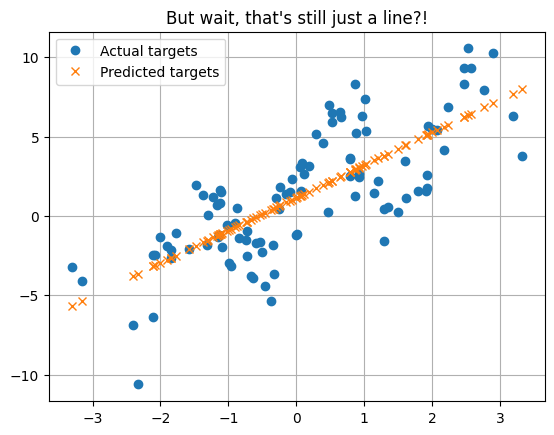

In [21]:
# We can build more complex models by stringing together more operations inside nn.Sequential:
model =  nn.Sequential(
    nn.Linear(in_features = 1, out_features = 1),
    nn.Linear(1,1)
)

train_and_test_regression_model(model)
_ = plt.title("But wait, that's still just a line?!")

---

**Question**: Why is it still just a line? How can we fix it? 

---

Epoch 1. MSE Loss = 15.631
Epoch 101. MSE Loss = 7.572
Epoch 201. MSE Loss = 7.014
Epoch 301. MSE Loss = 6.965
Epoch 401. MSE Loss = 6.940
Epoch 501. MSE Loss = 6.922
Epoch 601. MSE Loss = 6.907
Epoch 701. MSE Loss = 6.896
Epoch 801. MSE Loss = 6.887
Epoch 901. MSE Loss = 6.880


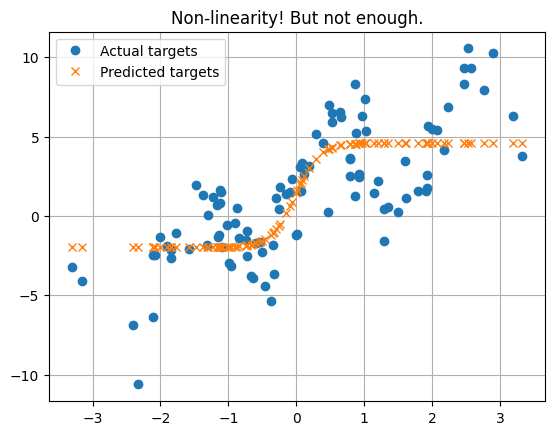

In [22]:
# We need a non-linearity between the two linear operations
model =  nn.Sequential(
    nn.Linear(in_features = 1, out_features = 1),
    nn.Tanh(),
    nn.Linear(1,1)
)
# this model does not reduce to a linear operation

train_and_test_regression_model(model)
_ = plt.title("Non-linearity! But not enough.")

Epoch 1. MSE Loss = 17.355
Epoch 5001. MSE Loss = 2.108
Epoch 10001. MSE Loss = 1.754
Epoch 15001. MSE Loss = 1.412
Epoch 20001. MSE Loss = 1.390
Epoch 25001. MSE Loss = 1.473
Epoch 30001. MSE Loss = 0.707
Epoch 35001. MSE Loss = 0.664
Epoch 40001. MSE Loss = 0.695
Epoch 45001. MSE Loss = 1.219


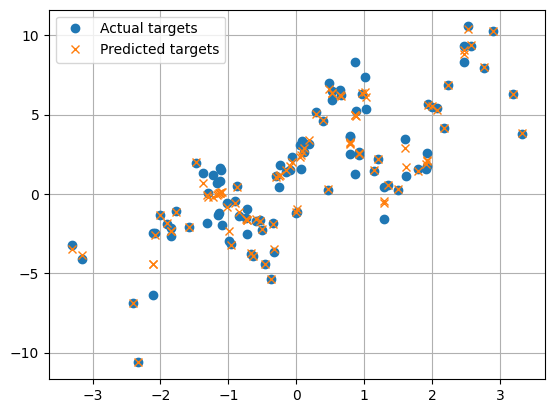

In [23]:
# Let's really crank up the number of hidden nodes
model =  nn.Sequential(
    nn.Linear(in_features = 1, out_features = 30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,30),
    nn.Tanh(),
    nn.Linear(30,1)
)

train_and_test_regression_model(model, num_epochs=50000, reporting_interval=5000)

---

**Question**: What is wrong with this picture? 

---

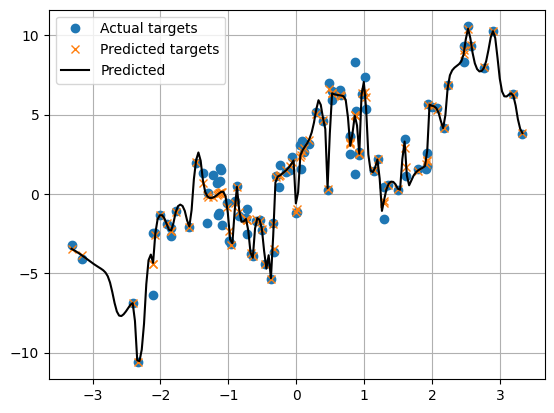

In [24]:
with torch.no_grad():
    x_grid = torch.linspace(x_reg.min(), x_reg.max(), 200)[:,None]
    y_reg_grid = model(x_grid)
    y_reg_init = model(x_reg)
plt.plot(x_reg.cpu(), y_reg.cpu(), 'o', label='Actual targets')
plt.plot(x_reg.cpu(), y_reg_init.cpu(), 'x', label='Predicted targets')
plt.plot(x_grid.cpu(), y_reg_grid.cpu(), 'k-', label='Predicted')
plt.grid()
plt.legend()

---

**Question**: Where is overfitting most severe? How might having more data alleviate the problem? 

---

---

🔥**IMPORTANT CONCEPT**🔥 Overfitting is a type of error that occurs when your model memorizes the training samples and fails to generalize to unseen data. This usually ocurrs when the model has excess capacity. 

---

---

😅**EXCERCISE**😅 Using the code cell below, design and test a model that gets it "just right".

---

In [25]:
#model = your model goes here

# train_and_test_regression_model(model, num_epochs=10000, reporting_interval=1000)

### Classification

Let's apply the same non-linear treatment to the case of classification.

Epoch 1. MSE Loss = 0.748
Epoch 1001. MSE Loss = 0.674
Epoch 2001. MSE Loss = 0.665
Epoch 3001. MSE Loss = 0.640
Epoch 4001. MSE Loss = 0.589
Epoch 5001. MSE Loss = 0.548
Epoch 6001. MSE Loss = 0.522
Epoch 7001. MSE Loss = 0.507
Epoch 8001. MSE Loss = 0.497
Epoch 9001. MSE Loss = 0.492


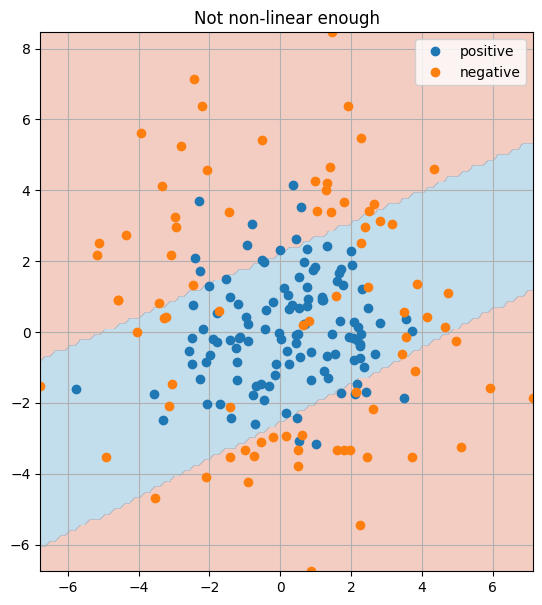

In [26]:
model =  nn.Sequential(
    nn.Linear(in_features = 2, out_features = 2),
    nn.Tanh(),
    nn.Linear(2,1),
    nn.Sigmoid()
)

train_and_test_classification_model(model, 10000, 1000)
_ = plt.title("Not non-linear enough")

---

**Question**: What would overfitting look like in this type of graph? 

---

Epoch 1. MSE Loss = 0.697
Epoch 3001. MSE Loss = 0.276
Epoch 6001. MSE Loss = 0.251
Epoch 9001. MSE Loss = 0.236
Epoch 12001. MSE Loss = 0.221
Epoch 15001. MSE Loss = 0.211
Epoch 18001. MSE Loss = 0.189
Epoch 21001. MSE Loss = 0.171
Epoch 24001. MSE Loss = 0.151
Epoch 27001. MSE Loss = 0.136


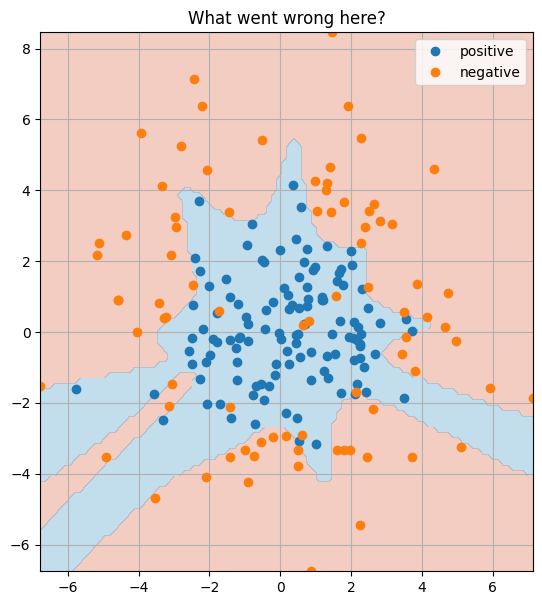

In [27]:
model =  nn.Sequential(
    nn.Linear(in_features = 2, out_features = 50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,50),
    nn.Tanh(),
    nn.Linear(50,1),
    nn.Sigmoid()
)

train_and_test_classification_model(model, 30000, 3000)
_ = plt.title("What went wrong here?")

---

**Question**: What's wrong with this picture?

---

---

😅**EXCERCISE**😅 Using the code cell below, design and test a model that gets it "just right".

---

In [28]:
#model = your model goes here

# train_and_test_classification_model(model, 20000, 2000)

### Summing up fully connected neural networks
* Fully connected neural networks can represent highly non-linear functions
* We can learn good functions through gradient descent
* Overfitting is a big problem

These concepts apply to nearly any neural network trained with gradient descent from the smallest fully connected net to GPT-4. 

## High Dimensional Data

For high-dimensional data, it is not possible to get a dense sampling of the data space. Consider the following analogy. Imagine we are measuring the temperatures of different spaces. We have sensors that measure reliably within a "volume" 1mm in extent. Outside of that volume, the temperature may change, so we need lots of sensors to map the temperature through the space. 
* 1D space: The total space is 1 m. You are given 100 sensors; each 1mm extent. The most you could fill up is 1/10th of the space
* 2D space: The total space is 1 m^2. You are given 100 sensors; each 1mm^2. The most you could fill up is 100mm^2 / (1000 mm)^2 = 1/10000th of the space. To cover 1/10th of the space, you would need 100,000 sensors!
* 3D space: The total space is 1 m^3. You are given 100 sensors; each 1mm^3. The most you could fill up is 100 mm^3 / (1000 mm)^3 = 1/10^7th of the space. To cover 1/10th of the space, you would need 100,000,000 sensors! 

You see where this is going. This is called THE CURSE OF DIMENSIONALITY.

In deep learning, we often work in data spaces with hundreds or thousands of dimensions, so... are we out of luck?

---

🔥**IMPORTANT CONCEPT**🔥 The CURSE OF DIMENSIONALITY refers to the fact that in high dimensional space, it is impossible to get dense coverage of the data space.

---

---

**Question**: Think back to the overfit regression model above. How might the curse of dimensionality make the overfitting problem worse? Why are deep neural networks especially problematic in this regard? 

---

---

**Question**: How might THE CURSE OF DIMENSIONALITY pose a problem for real-world tasks like computer vision for autonomous driving? 

---

### Fake high-dimensional data

In [29]:
# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [30]:
# this dataset is a lot bigger, so we're going to switch over to gpu
# pytorch makes this easy
device = torch.device('cuda')

In [31]:
# make some non-linear, fake data
n_samples = 100000
n_test = 20000
n_dims = 1000

w1 = torch.randn(n_dims, 128)
w2 = torch.randn(128)
b1 = torch.randn(128)
b2 = torch.randn(1)
noise = 1 * torch.randn(n_samples)

X = torch.randn(n_samples, n_dims)
y = torch.tanh(X @ w1 + b1) @ w2 + b2 + noise

# move to gpu:
X = X.to(device)
y = y.to(device)

X.shape, y.shape

(torch.Size([100000, 1000]), torch.Size([100000]))

### Splitting into train/test

In [32]:
# train/test split
X_train, X_test = X[:-n_test], X[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

((torch.Size([80000, 1000]), torch.Size([80000])),
 (torch.Size([20000, 1000]), torch.Size([20000])))

### Fitting a model

In [33]:
# helper function for training/evaluation
def train_and_test_highdim(model, num_epochs=1000, reporting_interval=100):

    # create our optimizer object and tell it about the parameters in our model
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # how many times to update the model based on the available data
    epoch_ls = []
    train_losses = []
    test_losses = []
    for i in range(num_epochs):
        optimizer.zero_grad()

        y_hat = model(X_train).squeeze()
        loss = torch.mean((y_hat - y_train)**2)

        # update the model
        loss.backward() # gradient computation
        optimizer.step()  # weight updates

        if i % reporting_interval == 0:
            
            # Evaluate on test data
            # turn off gradient tracking for this step:
            with torch.no_grad():
                y_hat = model(X_test).squeeze()
                test_loss = torch.mean((y_hat - y_test)**2)
                
            print(f"Epoch {str(i+1).zfill(5)}", end='\r')
            
            epoch_ls.append(i)
            train_losses.append(loss.detach().item())
            test_losses.append(test_loss.item())
            
    plt.plot(epoch_ls, train_losses, label='train')
    plt.plot(epoch_ls, test_losses, label='test')
    plt.grid()
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

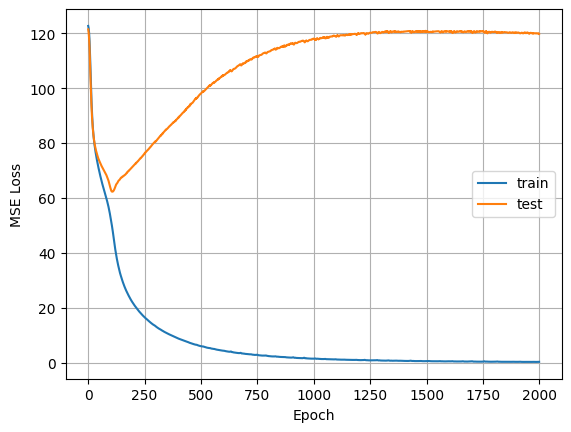

In [34]:
# This architecture is intentionally designed to overfit
model =  nn.Sequential(
    nn.Linear(in_features = n_dims, out_features = 128),
    nn.Tanh(),
    nn.Linear(128,128),
    nn.Tanh(),
    nn.Linear(128,64),
    nn.Tanh(),
    nn.Linear(64,50),
    nn.Tanh(),
    nn.Linear(50,1)
)

# move model to gpu:
model = model.to(device)

train_and_test_highdim(model, 2000, 1)

---

**Question**: Why does the plot look like that?

---

---

**Question**: Does this plot suggest a way that we could mitigate overfitting? 

---


---

😅**EXCERCISE**😅 Using the code cell below, designed and test a biased model. How do the training curves differ?

---

In [35]:
#model = your biased model goes here

#model = model.to(device)

# train_and_test_highdim(model, 2000, 1)

### Summing up high dimensional data
* Overfitting problems become much worse for high-dimensional data due to the curse of dimensionality
* To test for overfitting, it is critical to evaluate your model on different data than you used to train your model
* Much of the technical progress in deep learning over the last decade can be viewed as better ways to prevent overfitting.

The significance of the challenge of overfitting for deep learning cannot be overstated!